In [76]:
from data_utils import CustomImageDataset
import torch
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [77]:
plt.style.use("ggplot")

In [78]:
class ConvAutoencoder(nn.Module):
    def __init__(self, input_c=1):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(input_c, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, input_c, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

In [79]:
torch.manual_seed(0)

In [80]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cuda


In [81]:
batch_size = 128

In [82]:
# transform = transforms.Compose(
#     [transforms.ToPILImage(),
#      transforms.ToTensor(),
#      transforms.Normalize(mean=(0), std=(1)),
#      transforms.Resize((28, 28)),
#      transforms.RandomAdjustSharpness(9, p=1),
#      ])
# transform = transforms.Compose(
#     [transforms.ToPILImage(),
#      transforms.ToTensor(),
#      transforms.Normalize(mean=(0), std=(1)),
#      transforms.Resize((28, 28)),
#      transforms.RandomAdjustSharpness(9, p=1),
#      transforms.Grayscale(1),
#      ])
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0), std=(1)),
     transforms.RandomAdjustSharpness(5, p=1),
     transforms.Resize((28, 48)),
     transforms.CenterCrop((28, 28)),
     transforms.GaussianBlur(3),
     ])

In [83]:
train_data_path = "./homework_2_dataset/dataset/train"
train_dataset = CustomImageDataset(os.path.join(train_data_path, "annotation.txt"), os.path.join(train_data_path, "imgs"), transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [84]:
proliv_data_path = "./homework_2_dataset/dataset/proliv"
proliv_dataset = CustomImageDataset(os.path.join(proliv_data_path, "annotation.txt"), os.path.join(proliv_data_path, "imgs"), transform=transform)
proliv_dataloader = DataLoader(proliv_dataset, batch_size=batch_size, shuffle=True)

In [85]:
test_data_path = "./homework_2_dataset/dataset/test"
test_dataset = CustomImageDataset(os.path.join(test_data_path, "annotation.txt"), os.path.join(test_data_path, "imgs"), transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [86]:
model = ConvAutoencoder(input_c=3).to(device)
opt = torch.optim.Adam(model.parameters())

for epoch in tqdm.tqdm(range(15)):
    model.train()
    train_count = 0
    running_loss = 0
    for x, y in train_dataloader:
        train_count += 1
        x = x.to(device) # GPU
        opt.zero_grad()
        x_hat = model(x)
        loss = ((x - x_hat)**2).sum()
        running_loss += loss / batch_size
        loss.backward()
        opt.step()
    
    model.eval()
    val_count = 0
    val_loss = 0
    with torch.no_grad():
        for x, y in proliv_dataloader:
            val_count += 1
            x = x.to(device) # GPU
            reconstruction = model(x)
            loss = ((x - reconstruction)**2).sum()
            val_loss += loss / batch_size
    print(f"epoch {epoch}: train loss {running_loss / train_count}, validation loss {val_loss / val_count}")

  0%|          | 0/15 [00:00<?, ?it/s]

e:\2023_processing_and_generating_images_course_homeworks\venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  7%|▋         | 1/15 [00:11<02:36, 11.20s/it]

epoch 0: train loss 19.252864837646484, validation loss 21.946455001831055


 13%|█▎        | 2/15 [00:22<02:26, 11.30s/it]

epoch 1: train loss 7.9039692878723145, validation loss 16.917085647583008


 20%|██        | 3/15 [00:34<02:16, 11.37s/it]

epoch 2: train loss 5.423365116119385, validation loss 12.77830696105957


 27%|██▋       | 4/15 [00:46<02:11, 11.92s/it]

epoch 3: train loss 3.017502784729004, validation loss 9.613624572753906


 33%|███▎      | 5/15 [00:58<01:57, 11.80s/it]

epoch 4: train loss 2.232544183731079, validation loss 8.25042724609375


 40%|████      | 6/15 [01:09<01:45, 11.68s/it]

epoch 5: train loss 2.008549690246582, validation loss 7.3822221755981445


 47%|████▋     | 7/15 [01:21<01:32, 11.58s/it]

epoch 6: train loss 1.8648079633712769, validation loss 7.413603782653809


 53%|█████▎    | 8/15 [01:32<01:20, 11.47s/it]

epoch 7: train loss 1.7307658195495605, validation loss 7.292547225952148


 60%|██████    | 9/15 [01:43<01:08, 11.44s/it]

epoch 8: train loss 1.635240077972412, validation loss 7.001644134521484


 67%|██████▋   | 10/15 [01:55<00:57, 11.51s/it]

epoch 9: train loss 1.5864025354385376, validation loss 6.66953706741333


 73%|███████▎  | 11/15 [02:07<00:46, 11.55s/it]

epoch 10: train loss 1.564754605293274, validation loss 7.153894901275635


 80%|████████  | 12/15 [02:18<00:34, 11.57s/it]

epoch 11: train loss 1.5435956716537476, validation loss 7.29460334777832


 87%|████████▋ | 13/15 [02:30<00:23, 11.62s/it]

epoch 12: train loss 1.5215210914611816, validation loss 6.9097208976745605


 93%|█████████▎| 14/15 [02:42<00:11, 11.60s/it]

epoch 13: train loss 1.513570785522461, validation loss 7.056883335113525


100%|██████████| 15/15 [02:53<00:00, 11.57s/it]

epoch 14: train loss 1.4926124811172485, validation loss 7.1880693435668945


In [87]:
model.eval()
proliv_dataloader = DataLoader(proliv_dataset, batch_size=1, shuffle=True)
with torch.no_grad():
    losses = []
    true = []

    for x, y in proliv_dataloader:

        true.append(int(y[0]))
        x = x.to(device) # GPU
        reconstruction = model(x)
        loss = ((x - reconstruction)**2).sum()
        losses.append(loss.item())

thresolds, tp_rate = [], []
best_tresholds = []
for thresh in range(1, 6000, 1):
    tp, fp, tn, fn = 0, 0, 0, 0
    for loss, y in zip(losses, true):
        if loss >= (thresh / 100):
            y_pred = 1
        else:
            y_pred = 0
        
        if y == 1 and y_pred == 1:
            tp += 1
        elif y == 1 and y_pred == 0:
            fn += 1
        elif y == 0 and y_pred == 1:
            fp += 1
        elif y == 0 and y_pred == 0:
            tn += 1
    
    thresolds.append(thresh / 100)
    tp_rate.append(tp / (tp + fn))

    if tp / (tp + fn) == 1:
        best_tresholds.append(thresh / 100)
        # print(f"threshold = {(thresh / 10):.2f}: True Positive Rate: {(tp / (tp + fn)):.2f}")

if len(best_tresholds) > 0:
    print(f"choosen threshold: {np.quantile(best_tresholds, 0.9)}")
else:
    print("no possible thresholds")

choosen threshold: 2.3680000000000003


In [88]:

tp, fp, tn, fn = 0, 0, 0, 0
for x, y in test_dataloader:

    x = x.to(device) # GPU
    reconstruction = model(x)
    loss = ((x - reconstruction)**2).sum()

    if loss >= np.quantile(best_tresholds, 0.9):
        y_pred = 1
    else:
        y_pred = 0
    
    if int(y[0]) == 1 and y_pred == 1:
        tp += 1
    elif int(y[0]) == 1 and y_pred == 0:
        fn += 1
    elif int(y[0]) == 0 and y_pred == 1:
        fp += 1
    elif int(y[0]) == 0 and y_pred == 0:
        tn += 1
    
tp_rate = tp / (tp + fn)
tn_rate = tn / (tn + fp)

print(f"True Positive Rate: {(tp / (tp + fn)):.2f}, True Negative Rate: {(tn / (tn + fp)):.2f}, Threshold: {np.quantile(best_tresholds, 0.9)}")

True Positive Rate: 0.84, True Negative Rate: 0.83, Threshold: 2.3680000000000003


In [89]:
model.eval()
with torch.no_grad():
    losses = []
    true = []

    for x, y in test_dataloader:

        true.append(int(y[0]))
        x = x.to(device) # GPU
        reconstruction = model(x)
        loss = ((x - reconstruction)**2).sum()
        losses.append(loss.item())

thresolds, tp_rate, tn_rate = [], [], []
for thresh in range(1, 6000, 1):
    tp, fp, tn, fn = 0, 0, 0, 0
    for loss, y in zip(losses, true):
        if loss >= (thresh / 100):
            y_pred = 1
        else:
            y_pred = 0
        
        if y == 1 and y_pred == 1:
            tp += 1
        elif y == 1 and y_pred == 0:
            fn += 1
        elif y == 0 and y_pred == 1:
            fp += 1
        elif y == 0 and y_pred == 0:
            tn += 1
    
    thresolds.append(thresh / 100)
    tp_rate.append(tp / (tp + fn))
    tn_rate.append(tn / (tn + fp))

    if tp / (tp + fn) > 0.91 and tn / (tn + fp) > 0.91:
        print(f"threshold = {(thresh / 100):.2f}: True Positive Rate: {(tp / (tp + fn)):.2f}, True Negative Rate: {(tn / (tn + fp)):.3f}")

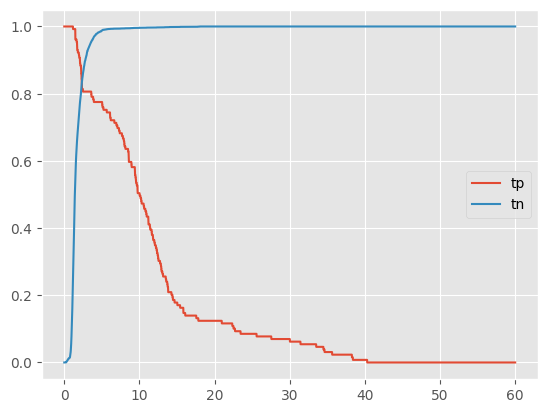

In [90]:
plt.plot(thresolds, tp_rate, label="tp")
plt.plot(thresolds, tn_rate, label="tn")
plt.legend() 
plt.show()